In [33]:
import os
import random as rd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from h2pc import H2PC
from hpc import hpc
import pandas as pd

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from independances import indepandance, plot_independance_tests, plot_indep_time_computation
from sklearn import preprocessing
from hpc import hpc
from utils import format_test
from comparaison_python import plot_ratio_algorithms, plot_score_algorithms




## Compute data and use an already known structure


In [3]:
asia_bn=gum.loadBN(os.path.join("true_graphes_structures","asia.bif"))
sizes=[2000,5000,10000]   
lindep=[("asia","smoke",['lung']), ("asia","smoke",[]),
                                   ("dysp","smoke",[]),
                                    ("dysp","smoke",["lung","bronc"]),
                                    ("tub","bronc",[]),
                                    ("tub","bronc",["dysp"])]
#generate database of asia and collect the corresponding dataframe
#we keep the labels to avoid misconfusing with id nodes
gum.generateCSV(asia_bn,os.path.join("databases","sample_asia.csv"),20000,visible=False,with_labels=True)
df_asia=pd.read_csv(os.path.join("databases","sample_asia.csv"))
learner=gum.BNLearner(os.path.join("databases","sample_asia.csv"))
  

# Test independance tests (R, PyAgrum and personnal version) on Asia network


Several possibilities are offered among all possible independance tests, we can combine *30* possible combinations in total:

* main criterias are the stat computed :"pearson","log-likelihood","freeman-tukey","mod-log-likelihood","cressie-read"
* and the way to adjust degrees of freedom to the observed simulation: "classic","adjusted","permut","permut_adjusted","semi_parametric"

Besides, it's also possible to choose among R, Pyagrum (only for person and log method, with classic dof) and own library to perform the tests. As you will see, Pyagrum is the fastest way.


In [3]:
for test in lindep:
    print("{} with p-value of {}".format(format_test(test),indepandance(df_asia,*test).realize_test()[1]))

asia indep smoke given ['lung'] ? with p-value of 0.10985459006771792
asia indep smoke ? with p-value of 0.6803771363735471
dysp indep smoke ? with p-value of 0.0
dysp indep smoke given ['lung', 'bronc'] ? with p-value of 0.22572815670032897
tub indep bronc ? with p-value of 0.16914258514458547
tub indep bronc given ['dysp'] ? with p-value of 0.0


## Measure independance for several algorithms on each conditionnal test of lindep


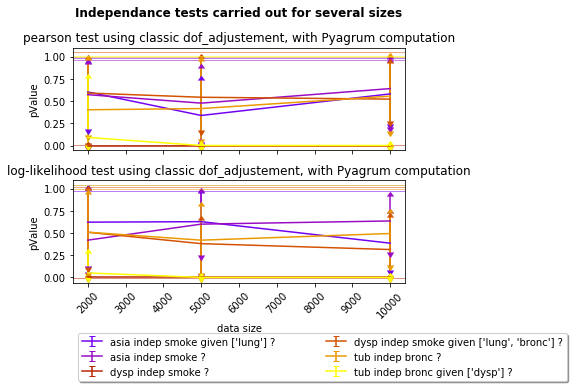

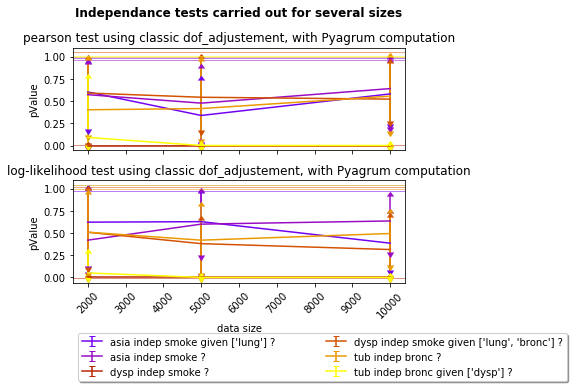

In [4]:
#to assert each value measured, we repeat 20 times the test
indep_criterion=[{"usePyAgrum":True},{"usePyAgrum":True,"calculation_method":"log-likelihood"}]
plot_independance_tests(df_asia,asia_bn,sizes,lindep,nb_test=10,list_args_independance=indep_criterion)

Something strange we can point out from the observed graphics is in opposition to what we could expect,
confidence intervals stay approximately the same, even by increasing the size of the dataset.
Problem coming from the method gum.generateCSV?

## Comparison of time computation
We can plot differences of time computation according to our 3 methods to perform the same computation : 
* using R libraries
* using PyAgrum library 
* using our library.



KeyboardInterrupt: 

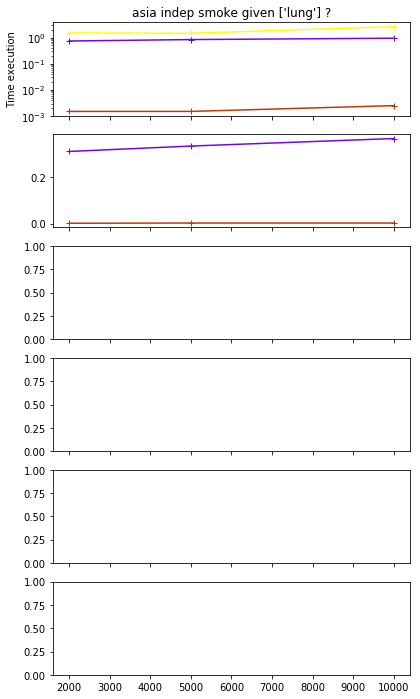

In [6]:
ntimes=20
plot_indep_time_computation(asia_bn,lindep, ntimes,sizes,list_args_independance=[{"calculation_method":"pearson"},{"usePyAgrum":True,"calculation_method":"pearson"},{"R_test":True,"calculation_method":"pearson"}])

We can see that PyAgrum is clearly the fastest way to compute independance tests, but only present for the moment two possibilities to compute indepandance tests.


Our library comes in second, but takes between 10 and 100 times more to compute the tests. Howvever, it's richer to perform 
some more complex, elaborate indepandance tests.


Eventually, R library is cleary the slowiest one. Nonenetheless, most of the time used to compute with R libraries
comes from converting Python types, such as dataframes, to R types, in order to execute on them the indepandance tests of library bnlearn.

## Use HPC to compute the local set of parents and children
Let's see if we can find for several variables their neighbourhood using HPC algorithm.

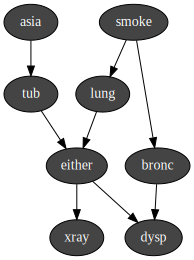

In [7]:
#plot asia bn
gnb.showBN(asia_bn)

In [8]:
couverture_markov_either=hpc('either',df_asia,learner=learner,usePyAgrum=True).couverture_markov()
print("Blanket markov found is {} .".format(couverture_markov_either))
id_either=asia_bn.idFromName('either')
neighbours_either={asia_bn.names()[node] for node in asia_bn.children(id_either).union(asia_bn.parents(id_either))}
print("True neighbours are {}".format(neighbours_either ))

couverture_markov_bronc=hpc('bronc',df_asia,learner=learner,usePyAgrum=True).couverture_markov()
print("Blanket markov found is {} .".format(couverture_markov_bronc))
id_bronc=asia_bn.idFromName('bronc')
neighbours_bronc={asia_bn.names()[node] for node in asia_bn.children(id_bronc).union(asia_bn.parents(id_bronc))}
print("True neighbours are {}".format(neighbours_bronc ))
neighbours_bronc==couverture_markov_bronc



Blanket markov found is {'lung', 'xray', 'tub', 'dysp'} .
True neighbours are {'lung', 'xray', 'tub', 'dysp'}
Blanket markov found is {'smoke', 'dysp'} .
True neighbours are {'smoke', 'dysp'}


True

# Use H2PC to compute bayesian network from the data

We can play on several parameters to modify the bayesian network:
* we can of course set up the several criterias of indepandance used to compute the Blanket Markov of each variable
* we can modify the scoring function used in the second phase for learning the structure (tabu search and greedy search), and add its potential parameters
* Filtering: to accept or not assymetries in the blanket markovs (with and, we force the program to erase a variable 1 if it's present in one of the MB of a target variable, and not the other one)
* optimized: instead of starting from scratches for each variable, we use the pre-information processed to speed up the process


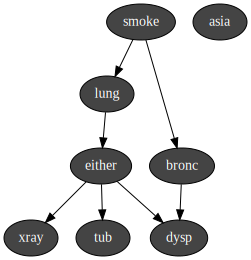

In [9]:

bn_H2PC_asia=H2PC(learner,df_asia,score_algorithm="tabu_search",optimized=False,filtering="AND",usePyAgrum=True).learnBN()
gnb.showBN(bn_H2PC_asia)

# Compare Learning algorithms
Here, we are going to compare the H2PC hybrid-bases algorithm, with some scoring algorithms already implemented in PyAgrum. First, we do that by comparing graphically the networks, then by using scoring functions. 

## Studies on Asia BN

In [11]:
#for asia bn
learner.useMIIC()
bn_miic=learner.learnBN()

learner.useGreedyHillClimbing()
bn_greedy=learner.learnBN()

learner.use3off2()
bn_3off2=learner.learnBN()

learner.useLocalSearchWithTabuList()
bn_tabulist=learner.learnBN()

gnb.sideBySide(gnb.getBNDiff(bn_miic,asia_bn),gnb.getBNDiff(bn_greedy,asia_bn),gnb.getBNDiff(bn_3off2,asia_bn),gnb.getBNDiff(bn_tabulist,asia_bn),gnb.getBNDiff(bn_H2PC_asia,asia_bn),
               captions=["BN  from miic","BN from greedy", "BN  from 3off2",
                        "BN from TabuList",
                        "BN from H2PC"])

    


BN from miic,BN from greedy,BN from 3off2,BN from TabuList,BN from H2PC


Key parameters for plotting score measures using several algorithms are:
* the bayesian network to enter (in our case, I add an input function to choose within the prevalent algorithms).Without it, you must enter the path to access to the corresponding file.
* the several sizes for which we try to infer the structure
* a list of the scores measures we want
* a list of algorithms, with as a key the name of the algo, and as value a tuple of args and kwargs corresponding to algo parameters
* the number of repetitions for each score measure, for each size to assert the computation

In [13]:
sample_size=[200,500,1000]
#storing of true graph structures
bn_path="asia.bif"
fig=plot_score_algorithms(bn_path,sizes,['recall','fscore','dist2opt','specificity'],algorithms={'miic':([],{}),'H2PC':([],{'optimized':False,'filtering':"AND",'usePyAgrum':True})},nsamples=30)
plt.savefig(os.path.join("figures","asia_scores"))

nous en sommes a l'algo  ('miic', ([], {})) pour al taille suivante de database  2000
nous en sommes a l'algo  ('H2PC', ([], {'optimized': False, 'filtering': 'AND', 'usePyAgrum': True})) pour al taille suivante de database  2000


KeyboardInterrupt: 

## Studies on alarm BN

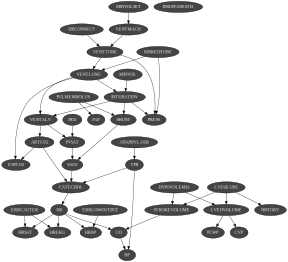

In [16]:
alarm_bn=gum.loadBN(os.path.join("true_graphes_structures","alarm.bif"))
sizes=[2000,5000,10000,20000]   
gum.generateCSV(alarm_bn,os.path.join("databases","sample_alarm.csv"),20000,visible=False,with_labels=True)
df_alarm=pd.read_csv(os.path.join("databases","sample_alarm.csv"))
learner=gum.BNLearner(os.path.join("databases","sample_alarm.csv"))

bn_H2PC_alarm=H2PC(learner,df_alarm,score_algorithm="tabu_search",optimized=False,filtering="AND",usePyAgrum=True).learnBN()
gnb.showBN(bn_H2PC_alarm)

In [19]:
learner.useMIIC()
bn_miic=learner.learnBN()

learner.useGreedyHillClimbing()
bn_greedy=learner.learnBN()

learner.use3off2()
bn_3off2=learner.learnBN()

learner.useLocalSearchWithTabuList()
bn_tabulist=learner.learnBN()

gnb.sideBySide(gnb.getBNDiff(bn_miic,alarm_bn),gnb.getBNDiff(bn_greedy,alarm_bn),gnb.getBNDiff(bn_3off2,alarm_bn),gnb.getBNDiff(bn_tabulist,alarm_bn),gnb.getBNDiff(bn_H2PC_alarm,alarm_bn),
               captions=["BN  from miic","BN from greedy", "BN  from 3off2",
                        "BN from TabuList",
                        "BN from H2PC"])




BN from miic,BN from greedy,BN from 3off2,BN from TabuList,BN from H2PC


In [24]:
bn_path=os.path.join("alarm.bif")
fig=plot_score_algorithms(bn_path,sizes,['recall','fscore','dist2opt','specificity'],algorithms={'miic':([],{}),'H2PC':([],{'optimized':False,'filtering':"AND",'usePyAgrum':True})},nsamples=30)
plt.savefig(os.path.join("figures","alarm_scores"))

nous en sommes a l'algo  ('miic', ([], {})) pour al taille suivante de database  2000


KeyboardInterrupt: 

We also have the choice to **plot ratios**, with **boxplot distribution** for each measure. In that case, we can compare only two algorithms in the same time (more will lead to blur graphics, and so our program yield an error). Usually, it's the ratio of second algo to first algo. Parameters are rather the same as for *plot_score_algorithms*.

In [34]:
fig=plot_ratio_algorithms(bn_path,sizes,score_measured=['dist2opt','recall'],algorithms={'tabu_search':([20,50],{}),'H2PC':([],{'optimized':False,'filtering':"AND",'usePyAgrum':True})},nsamples=20)
plt.savefig(os.path.join("figures","alarm_ratios"))

Exception: extension true_graphes_structures\alarm unknown. Please use among bif|dsl|net|bifxml|o3prm|uai